In [2]:
from remote_vgk import *

import numpy as np
import matplotlib.pyplot as plt 
from buffet import cpstar_from_mach

In [3]:
def load_password(path):

    with open(path) as f:
        secrets = json.load(f)
        shifted_pwd = secrets['password']
    pwd = ''
    for s in shifted_pwd:
        pwd += chr(ord(s) - 1)

    return pwd

In [4]:
try:
    window = gw.getWindowsWithTitle("millenicut")[0]
except IndexError:
    raise Exception("Window not found")

pwd = load_password('secrets.json')
sesh = DPO_Session('lwp26', pwd)

# Create the AirfoilApp
App = AirfoilApp(sesh.teaching_client, window, "2.3_incidence_aerofoil")

# IMPORTANT SET THE SAME PARAMETERS AS ON THE APP
App.alpha = 2.3
App.M = 0.75
App.Re = 10


-0.6620962341011355


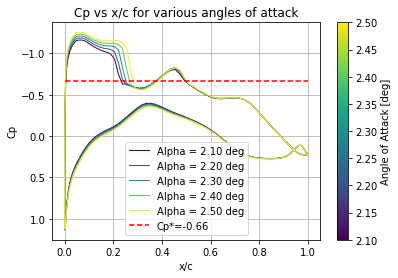

In [11]:
alphas = np.arange(2.1, 2.6, 0.1)
cs = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
M = 0.73

plt.gca().invert_yaxis()
i = 0

for alpha in alphas:
    res = App.run(M, alpha, 10)
    if res is None:
        continue

    plt.plot(res.x, res.cp, color=cs[i], linewidth = 1, label=f'Alpha = {alpha:.2f} deg')

    i += 1

cpstar = cpstar_from_mach(M)
print(cpstar)
plt.hlines(cpstar, 0, 1, 'r', '--')
 
# add colourbar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=alphas.min(), vmax=alphas.max()))
sm._A = []

plt.colorbar(sm, label='Angle of Attack [deg]')

plt.xlabel('x/c')
plt.ylabel('Cp')

plt.title('Cp vs x/c for various angles of attack')

plt.grid()
plt.legend()


plt.savefig('figures/cp_vs_xc_alphas.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


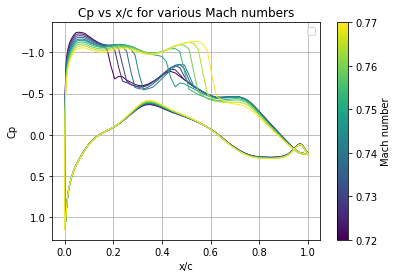

In [13]:
nmach = 10
alpha = 2.3
machs = np.linspace(0.72, 0.77, nmach)
cs = plt.cm.viridis(np.linspace(0, 1, nmach))

plt.gca().invert_yaxis()
i = 0

for m in machs:
    res = App.run(m, alpha, 10)
    if res is None:
        continue

    plt.plot(res.x, res.cp, color=cs[i], linewidth = 1)

    i += 1

# add colourbar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=machs.min(), vmax=machs.max()))
sm._A = []

plt.colorbar(sm, label='Mach number')

plt.xlabel('x/c')
plt.ylabel('Cp')

plt.title('Cp vs x/c for various Mach numbers')

plt.grid()
plt.legend()


plt.savefig('figures/cp_vs_xc_machs.png', dpi=400)

In [6]:
# 100 runs takes ~ 5 minutes
machs = np.linspace(0.76, 0.78, 2)
alphas = np.linspace(0, 2.5, 20)

for m in machs:
    for a in alphas:
        res = App.run(m, a, 10)


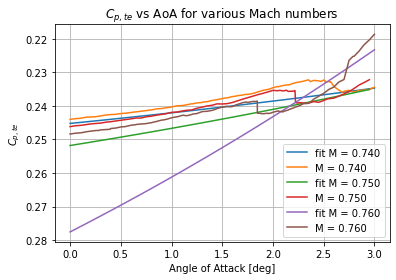

Socket exception: An existing connection was forcibly closed by the remote host (10054)


In [31]:

from scipy.optimize import curve_fit

def f(x, b, c):
    return b * np.exp(0.1 * x) + c

machs = np.arange(0.74, 0.76, 0.01)
for m in machs:
    als, cps = App.cpte_alpha(m, 10)

    idx = np.argmax(np.gradient(cps))
    als_fit = als[idx:]
    cps_fit = cps[idx:]

    try:
        popt, pcov = curve_fit(f, als_fit, cps_fit)
        x = np.linspace(als.min(), als_fit.max(), 100)
        y = f(x, *popt)
        plt.plot(x, y, label=f'fit M = {m:.3f}')
    except RuntimeError:
        pass
    
    plt.plot(als, cps, label=f'M = {m:.3f}')

plt.xlabel('Angle of Attack [deg]')
plt.ylabel('$C_{p,te}$')


# flip y axis
plt.gca().invert_yaxis()

plt.title('$C_{p,te}$ vs AoA for various Mach numbers')

plt.grid()
plt.legend()

plt.savefig('figures/cpte_vs_alpha_machs.png', dpi = 300)


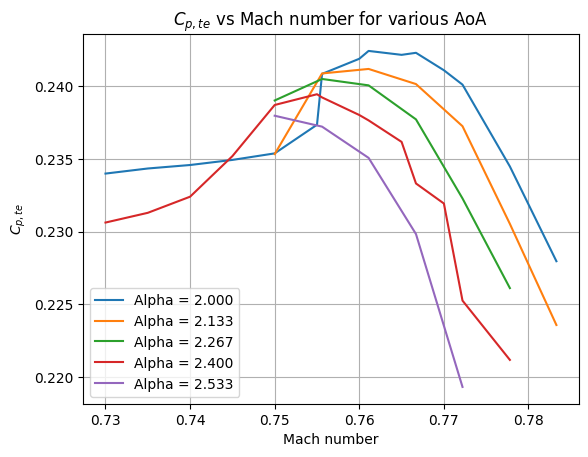

In [8]:
alphas = np.linspace(2, 2.6, 10)
for a in alphas[::2]:
    machs, cps = App.cpte_M(a, 10)

    plt.plot(machs, cps, label=f'Alpha = {a:.3f}')


plt.xlabel('Mach number')
plt.ylabel('$C_{p,te}$')

plt.title('$C_{p,te}$ vs Mach number for various AoA')

plt.grid()
plt.legend()


In [9]:
print(len(App))

4684


In [38]:

alpha = 2.3
Re = 10
Cds = []
Machs = []

for res in App:
    if np.isclose(res.alpha, alpha) and np.isclose(res.Re, Re):
        Cds.append(res.Cd)
        Machs.append(res.M)

# sort by mach
idx = np.argsort(Machs)
Cds = np.array(Cds)[idx]
Machs = np.array(Machs)[idx]

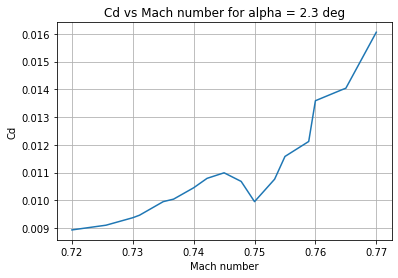

In [40]:
plt.plot(Machs, Cds)
plt.xlabel('Mach number')
plt.ylabel('Cd')

plt.title('Cd vs Mach number for alpha = 2.3 deg')
plt.grid()

plt.savefig('figures/cd_vs_mach.png', dpi=300)